In [476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import pickle

In [477]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [478]:
BASE_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Final Project'
print(os.listdir(BASE_FILE_PATH))

['Keys', 'Setting up connection with Git-Hub.ipynb', 'entries.csv', 'summoner_details.csv', 'updated_dataset.csv', 'filtered_dataset.csv', 'filtered_dataset.gsheet', 'filtered_+30_matches_dataset.csv', 'EDA.ipynb', 'merged_dataset.csv', 'Merging match with entries and classifying accounts.ipynb', 'merged_dataset.gsheet', 'Feature engineering and cleaning vol 1.ipynb', 'dataset_after_normalization.csv', 'keepign only win feature .ipynb', 'Models without data normalization.ipynb', 'Normalization_Parameters.csv', 'Normalization_Parameters_by_Team_Position.csv', 'Normalization_Parameters_by_Game_Mode.csv', 'summoner_ids_used_in_model.csv', 'gbm_model.pkl']


In [479]:
df = pd.read_csv(os.path.join(BASE_FILE_PATH, 'merged_dataset.csv'))

In [480]:
categorical_columns = ['game_mode', 'team_position', 'tier', 'rank']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_columns)

In [481]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   match_id               128021 non-null  object 
 1   game_creation          128021 non-null  int64  
 2   game_duration          128021 non-null  int64  
 3   game_version           128021 non-null  object 
 4   map_id                 128021 non-null  int64  
 5   summoner_id            128021 non-null  object 
 6   puuid                  128021 non-null  object 
 7   champion_id            128021 non-null  int64  
 8   kills                  128021 non-null  int64  
 9   deaths                 128021 non-null  int64  
 10  assists                128021 non-null  int64  
 11  total_damage_dealt     128021 non-null  int64  
 12  total_damage_taken     128021 non-null  int64  
 13  gold_earned            128021 non-null  int64  
 14  vision_score           128021 non-nu

In [482]:
#winsorizing features by game_mode = CHERRY to then normalize all features by game_mode
# Winsorize features only for CHERRY Game Mode
df_cherry = df[df['game_mode_CHERRY'] == True].copy()
features_to_winsorize = [
    'kills', 'deaths', 'assists', 'gold_earned', 'game_duration',
    'total_damage_dealt', 'total_damage_taken', 'total_minions_killed'
]

for feature in features_to_winsorize:
    df_cherry[f'{feature}_winsorized'] = winsorize(df_cherry[feature], limits=[0.01, 0.01])

# Update the main DataFrame only for CHERRY game mode rows
for feature in features_to_winsorize:
    df.loc[df['game_mode_CHERRY'], feature] = df_cherry[f'{feature}_winsorized']

# Normalize the features for each game mode separately
game_modes = ['game_mode_ARAM', 'game_mode_CHERRY', 'game_mode_CLASSIC']
for mode in game_modes:
    df_mode = df[df[mode] == True]
    scaler = StandardScaler()
    for feature in features_to_winsorize:
        if df_mode.shape[0] > 0:  # Check if there are entries for the mode
            df.loc[df[mode], f'{feature}_normalized'] = scaler.fit_transform(df_mode[[feature]])

# Check the dataframe info and head to confirm the changes
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 47 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   match_id                         128021 non-null  object 
 1   game_creation                    128021 non-null  int64  
 2   game_duration                    128021 non-null  int64  
 3   game_version                     128021 non-null  object 
 4   map_id                           128021 non-null  int64  
 5   summoner_id                      128021 non-null  object 
 6   puuid                            128021 non-null  object 
 7   champion_id                      128021 non-null  int64  
 8   kills                            128021 non-null  int64  
 9   deaths                           128021 non-null  int64  
 10  assists                          128021 non-null  int64  
 11  total_damage_dealt               128021 non-null  int64  
 12  to

,match_id,game_creation,game_duration,game_version,map_id,summoner_id,puuid,champion_id,kills,deaths,...,rank_III,rank_IV,kills_normalized,deaths_normalized,assists_normalized,gold_earned_normalized,game_duration_normalized,total_damage_dealt_normalized,total_damage_taken_normalized,total_minions_killed_normalized
0,NA1_4967002924,1712434308642,1087,14.7.571.9528,11,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,17,3,1,...,False,True,-0.678147,-1.383072,-0.420678,-1.258582,-1.226514,-1.324098,-1.407530,-1.025501
1,NA1_5050183543,1721508545865,1282,14.14.602.7801,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,30,14,19,...,False,True,0.391910,2.069280,0.183700,0.767557,0.509081,1.526262,0.600897,2.300653
2,NA1_5050376845,1721513174857,1327,14.14.602.7801,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,161,12,13,...,False,True,0.102877,0.597786,0.474439,0.249953,0.665935,0.901536,0.121671,0.760642
3,NA1_5052219350,1721575116568,1344,14.14.602.7801,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,15,6,20,...,False,True,-0.764221,2.314529,0.668265,0.293223,0.725191,1.470693,0.622514,2.169588
4,NA1_5052262521,1721577348686,1261,14.14.602.7801,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,238,11,16,...,False,True,-0.041639,1.333533,-0.591604,0.392009,0.435882,-0.211094,-0.075949,-0.713836


In [483]:
print(df[['kills_normalized', 'deaths_normalized', 'assists_normalized',
          'gold_earned_normalized', 'game_duration_normalized',
          'total_damage_dealt_normalized', 'total_damage_taken_normalized',
          'total_minions_killed_normalized']].describe())

       kills_normalized  deaths_normalized  assists_normalized  \
count      1.280210e+05       1.280210e+05        1.280210e+05   
mean      -7.370672e-17      -5.350397e-17       -6.438237e-18   
std        1.000004e+00       1.000004e+00        1.000004e+00   
min       -1.631318e+00      -2.590450e+00       -2.336038e+00   
25%       -6.781466e-01      -8.020271e-01       -7.728958e-01   
50%       -1.861553e-01       6.954001e-02       -2.445684e-01   
75%        5.364263e-01       6.505848e-01        4.744390e-01   
max        9.388125e+00       9.366256e+00        8.913106e+00   

       gold_earned_normalized  game_duration_normalized  \
count            1.280210e+05              1.280210e+05   
mean             1.468584e-16             -2.285574e-16   
std              1.000004e+00              1.000004e+00   
min             -3.330817e+00             -3.603981e+00   
25%             -6.436703e-01             -5.180360e-01   
50%             -2.988733e-02              5.943234

In [484]:
#Exporting the Normalization Params based on game_mode to use it in predictions on new players matches

features = ['kills', 'deaths', 'assists', 'gold_earned', 'game_duration',
            'total_damage_dealt', 'total_damage_taken', 'total_minions_killed']

game_modes = ['game_mode_ARAM', 'game_mode_CHERRY', 'game_mode_CLASSIC']

# DataFrame to hold the normalization parameters
norm_params = pd.DataFrame()

# Process each game mode separately
for mode in game_modes:
    df_mode = df[df[mode] == 1]  # Filter data for the current game mode
    scaler = StandardScaler()

    # Normalize the features and calculate the mean and standard deviation
    for feature in features:
        if df_mode.shape[0] > 0:
            scaled_feature = scaler.fit_transform(df_mode[[feature]])
            mean_val = scaler.mean_[0]  # Mean of the feature
            std_val = scaler.scale_[0]  # Std dev of the feature

            # Create a new DataFrame for the current row
            new_row = pd.DataFrame({
                'Game_Mode': [mode],
                'Feature': [feature],
                'Mean': [mean_val],
                'StdDev': [std_val]
            })
            norm_params = pd.concat([norm_params, new_row], ignore_index=True)

# Set column order and export to CSV
norm_params = norm_params[['Game_Mode', 'Feature', 'Mean', 'StdDev']]

# Export to CSV
norm_params.to_csv(os.path.join(BASE_FILE_PATH, 'Normalization_Parameters_by_Game_Mode.csv'), index=False)

In [485]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 47 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   match_id                         128021 non-null  object 
 1   game_creation                    128021 non-null  int64  
 2   game_duration                    128021 non-null  int64  
 3   game_version                     128021 non-null  object 
 4   map_id                           128021 non-null  int64  
 5   summoner_id                      128021 non-null  object 
 6   puuid                            128021 non-null  object 
 7   champion_id                      128021 non-null  int64  
 8   kills                            128021 non-null  int64  
 9   deaths                           128021 non-null  int64  
 10  assists                          128021 non-null  int64  
 11  total_damage_dealt               128021 non-null  int64  
 12  to

In [486]:
##Normalizing features based on the team_position
# Define the features to normalize
features_to_normalize = [
    'kills', 'deaths', 'assists', 'gold_earned',
    'total_damage_dealt', 'total_damage_taken', 'total_minions_killed'
]

# List of team positions based on your one-hot encoded columns
team_positions = ['All Mid', 'BOTTOM', 'Duo', 'JUNGLE', 'MIDDLE', 'TOP', 'UTILITY', 'Unknown']

# Normalize each feature within each team position
for position in team_positions:
    column_name = f'team_position_{position}'
    for feature in features_to_normalize:
        # Use the one-hot encoded column to filter the DataFrame
        subset = df[df[column_name] == 1]

        # Calculate mean and standard deviation for the feature within the subset
        mean_val = subset[feature].mean()
        std_val = subset[feature].std()

        # Normalize the feature within the team position and store in a new column
        df.loc[df[column_name] == 1, f'{feature}_normalized_{position}'] = (df[feature] - mean_val) / std_val

In [487]:
# DataFrame to hold the normalization parameters for all positions
all_positions_norm_params = pd.DataFrame()

# Loop through each position and calculate normalization parameters
for position in team_positions:
    column_name = f'team_position_{position}'
    subset = df[df[column_name] == 1]

    # List to collect DataFrame rows for the current position
    rows = []

    # Calculate mean and standard deviation for each feature in the current position
    for feature in features_to_normalize:
        mean_val = subset[feature].mean()
        std_val = subset[feature].std()

        # Create a dict for the current feature and append to the list
        row = {
            'Feature': feature,
            'Team_Position': position,
            'Mean': mean_val,
            'StdDev': std_val
        }
        rows.append(row)

    # Create a DataFrame from the rows list and concatenate it with the main DataFrame
    position_norm_params = pd.DataFrame(rows)
    all_positions_norm_params = pd.concat([all_positions_norm_params, position_norm_params], ignore_index=True)

# Export to CSV
all_positions_norm_params.to_csv(os.path.join(BASE_FILE_PATH, 'Normalization_Parameters_by_Team_Position.csv'), index=False)

In [488]:
df.columns.tolist()

['match_id',
 'game_creation',
 'game_duration',
 'game_version',
 'map_id',
 'summoner_id',
 'puuid',
 'champion_id',
 'kills',
 'deaths',
 'assists',
 'total_damage_dealt',
 'total_damage_taken',
 'gold_earned',
 'vision_score',
 'total_minions_killed',
 'win',
 'game_duration_min',
 'game_creation_dt',
 'time_segment',
 'days_since_last_game',
 'time_group',
 'binary_time_group',
 'game_mode_ARAM',
 'game_mode_CHERRY',
 'game_mode_CLASSIC',
 'team_position_All Mid',
 'team_position_BOTTOM',
 'team_position_Duo',
 'team_position_JUNGLE',
 'team_position_MIDDLE',
 'team_position_TOP',
 'team_position_UTILITY',
 'team_position_Unknown',
 'tier_GOLD',
 'rank_I',
 'rank_II',
 'rank_III',
 'rank_IV',
 'kills_normalized',
 'deaths_normalized',
 'assists_normalized',
 'gold_earned_normalized',
 'game_duration_normalized',
 'total_damage_dealt_normalized',
 'total_damage_taken_normalized',
 'total_minions_killed_normalized',
 'kills_normalized_All Mid',
 'deaths_normalized_All Mid',
 'assist

In [489]:
df['game_creation_dt'] = pd.to_datetime(df['game_creation_dt'])

# Define bins based on quantiles
quantiles = df['game_creation_dt'].quantile([0, 0.33, 0.67, 1]).to_list()
df['time_segment'] = pd.cut(df['game_creation_dt'], bins=quantiles, labels=['initial', 'mid', 'late'], include_lowest=True)

In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Columns: 103 entries, match_id to total_minions_killed_normalized_Unknown
dtypes: bool(17), category(1), datetime64[ns](1), float64(65), int64(13), object(6)
memory usage: 85.2+ MB


In [491]:
df.drop(columns=['game_creation_dt', 'time_group'], inplace=True)

In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Columns: 101 entries, match_id to total_minions_killed_normalized_Unknown
dtypes: bool(17), category(1), float64(65), int64(13), object(5)
memory usage: 83.3+ MB


In [493]:
# Removing original and unrelated feature columns
columns_to_drop = ['game_creation', 'game_duration', 'map_id', 'champion_id',
                   'kills', 'deaths', 'assists', 'total_damage_dealt',
                   'total_damage_taken', 'gold_earned', 'vision_score',
                   'total_minions_killed', 'game_duration_min'] + \
                  [f'{feat}_original' for feat in features_to_winsorize]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [494]:
df.columns.tolist()

['match_id',
 'game_version',
 'summoner_id',
 'puuid',
 'win',
 'time_segment',
 'days_since_last_game',
 'binary_time_group',
 'game_mode_ARAM',
 'game_mode_CHERRY',
 'game_mode_CLASSIC',
 'team_position_All Mid',
 'team_position_BOTTOM',
 'team_position_Duo',
 'team_position_JUNGLE',
 'team_position_MIDDLE',
 'team_position_TOP',
 'team_position_UTILITY',
 'team_position_Unknown',
 'tier_GOLD',
 'rank_I',
 'rank_II',
 'rank_III',
 'rank_IV',
 'kills_normalized',
 'deaths_normalized',
 'assists_normalized',
 'gold_earned_normalized',
 'game_duration_normalized',
 'total_damage_dealt_normalized',
 'total_damage_taken_normalized',
 'total_minions_killed_normalized',
 'kills_normalized_All Mid',
 'deaths_normalized_All Mid',
 'assists_normalized_All Mid',
 'gold_earned_normalized_All Mid',
 'total_damage_dealt_normalized_All Mid',
 'total_damage_taken_normalized_All Mid',
 'total_minions_killed_normalized_All Mid',
 'kills_normalized_BOTTOM',
 'deaths_normalized_BOTTOM',
 'assists_norma

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 88 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   match_id                                 128021 non-null  object  
 1   game_version                             128021 non-null  object  
 2   summoner_id                              128021 non-null  object  
 3   puuid                                    128021 non-null  object  
 4   win                                      128021 non-null  bool    
 5   time_segment                             128021 non-null  category
 6   days_since_last_game                     128021 non-null  int64   
 7   binary_time_group                        128021 non-null  object  
 8   game_mode_ARAM                           128021 non-null  bool    
 9   game_mode_CHERRY                         128021 non-null  bool    
 10  game_mode_CLASSIC   

In [496]:
df = df.drop([
    'game_mode_ARAM', 'game_mode_CHERRY', 'game_mode_CLASSIC',
    'team_position_All Mid', 'team_position_BOTTOM', 'team_position_Duo',
    'team_position_JUNGLE', 'team_position_MIDDLE', 'team_position_TOP',
    'team_position_UTILITY', 'team_position_Unknown', 'tier_GOLD',
    'rank_I', 'rank_II', 'rank_III', 'rank_IV', 'days_since_last_game'
], axis=1)

In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 71 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   match_id                                 128021 non-null  object  
 1   game_version                             128021 non-null  object  
 2   summoner_id                              128021 non-null  object  
 3   puuid                                    128021 non-null  object  
 4   win                                      128021 non-null  bool    
 5   time_segment                             128021 non-null  category
 6   binary_time_group                        128021 non-null  object  
 7   kills_normalized                         128021 non-null  float64 
 8   deaths_normalized                        128021 non-null  float64 
 9   assists_normalized                       128021 non-null  float64 
 10  gold_earned_normaliz

In [498]:
# Fill numeric columns with 0
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# For categorical columns, you might want to add a category, or convert to string
categorical_cols = df.select_dtypes(include=['category']).columns
for col in categorical_cols:
    df[col] = df[col].cat.add_categories([0]).fillna(0)

In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 71 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   match_id                                 128021 non-null  object  
 1   game_version                             128021 non-null  object  
 2   summoner_id                              128021 non-null  object  
 3   puuid                                    128021 non-null  object  
 4   win                                      128021 non-null  bool    
 5   time_segment                             128021 non-null  category
 6   binary_time_group                        128021 non-null  object  
 7   kills_normalized                         128021 non-null  float64 
 8   deaths_normalized                        128021 non-null  float64 
 9   assists_normalized                       128021 non-null  float64 
 10  gold_earned_normaliz

In [500]:
df.drop(columns=['win'], inplace=True)

In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 70 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   match_id                                 128021 non-null  object  
 1   game_version                             128021 non-null  object  
 2   summoner_id                              128021 non-null  object  
 3   puuid                                    128021 non-null  object  
 4   time_segment                             128021 non-null  category
 5   binary_time_group                        128021 non-null  object  
 6   kills_normalized                         128021 non-null  float64 
 7   deaths_normalized                        128021 non-null  float64 
 8   assists_normalized                       128021 non-null  float64 
 9   gold_earned_normalized                   128021 non-null  float64 
 10  game_duration_normal

In [502]:
df.head()

,match_id,game_version,summoner_id,puuid,time_segment,binary_time_group,kills_normalized,deaths_normalized,assists_normalized,gold_earned_normalized,...,total_damage_dealt_normalized_UTILITY,total_damage_taken_normalized_UTILITY,total_minions_killed_normalized_UTILITY,kills_normalized_Unknown,deaths_normalized_Unknown,assists_normalized_Unknown,gold_earned_normalized_Unknown,total_damage_dealt_normalized_Unknown,total_damage_taken_normalized_Unknown,total_minions_killed_normalized_Unknown
0,NA1_4967002924,14.7.571.9528,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,initial,Active,-0.678147,-1.383072,-0.420678,-1.258582,...,-0.610752,-1.275624,0.029368,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NA1_5050183543,14.14.602.7801,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,mid,Active,0.391910,2.069280,0.183700,0.767557,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NA1_5050376845,14.14.602.7801,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,mid,Active,0.102877,0.597786,0.474439,0.249953,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NA1_5052219350,14.14.602.7801,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,mid,Active,-0.764221,2.314529,0.668265,0.293223,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NA1_5052262521,14.14.602.7801,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,z_Fsi2R5ah8GZsOrkqpdobOUAqOZF3_eqwfuQctrX8ehlD...,mid,Active,-0.041639,1.333533,-0.591604,0.392009,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [503]:
# Exclude non-numeric columns from the DataFrame before grouping
numeric_cols = df.select_dtypes(include=[np.number])  # This selects only numeric columns
df_numeric = df[['summoner_id', 'time_segment'] + list(numeric_cols.columns)]

# Addressing the FutureWarning by setting observed=True if the DataFrame contains any categorical data
grouped_df = df_numeric.groupby(['summoner_id', 'time_segment'], observed=True).mean()

# Pivoting the data so each 'time_segment' becomes a column
pivot_df = grouped_df.unstack(level='time_segment')

# Flattening the columns to make them more manageable
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Resetting the index so 'summoner_id' becomes a column
pivot_df.reset_index(inplace=True)

# Optionally, fill any NaN values that may arise from empty segments
pivot_df.fillna(0, inplace=True)

# Display the first few rows to verify
print(pivot_df.head())

                                         summoner_id  \
0   --yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE   
1   -0FAl-E5gzHW35MsMHI7ZBv4jCme6S8TT2W7az4-G7x7Y-Yy   
2    -1ddPTjEGbdaQR2HcKWdP0qkBfSjsyJcFot0WGcyGxkjSy4   
3  -2ksdxdFEy1AnyqNsmO-RI_2n8ic7mAzN5-LYGvttHTwY2...   
4    -3ntNAfsqQ8f8pHSCh805dnhlQvmv2_GYLWxhwDfn6I1h2g   

   kills_normalized_initial  kills_normalized_mid  kills_normalized_late  \
0                 -0.678147             -0.245808              -0.521261   
1                 -0.203322             -0.583182              -0.062466   
2                  0.662533              0.320202               0.208192   
3                  0.366466              0.102462              -0.025106   
4                  0.370595              1.017654               0.000000   

   deaths_normalized_initial  deaths_normalized_mid  deaths_normalized_late  \
0                  -1.383072               0.594446                0.063105   
1                  -0.511505              -0.511

In [504]:
# Extract binary_time_group and summoner_id, and drop duplicates
binary_time_mapping = df[['summoner_id', 'binary_time_group']].drop_duplicates()

# Merge this mapping into the pivot_df
pivot_df = pivot_df.merge(binary_time_mapping, on='summoner_id', how='left')

# Display the first few rows to verify the merge
print(pivot_df.head())

                                         summoner_id  \
0   --yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE   
1   -0FAl-E5gzHW35MsMHI7ZBv4jCme6S8TT2W7az4-G7x7Y-Yy   
2    -1ddPTjEGbdaQR2HcKWdP0qkBfSjsyJcFot0WGcyGxkjSy4   
3  -2ksdxdFEy1AnyqNsmO-RI_2n8ic7mAzN5-LYGvttHTwY2...   
4    -3ntNAfsqQ8f8pHSCh805dnhlQvmv2_GYLWxhwDfn6I1h2g   

   kills_normalized_initial  kills_normalized_mid  kills_normalized_late  \
0                 -0.678147             -0.245808              -0.521261   
1                 -0.203322             -0.583182              -0.062466   
2                  0.662533              0.320202               0.208192   
3                  0.366466              0.102462              -0.025106   
4                  0.370595              1.017654               0.000000   

   deaths_normalized_initial  deaths_normalized_mid  deaths_normalized_late  \
0                  -1.383072               0.594446                0.063105   
1                  -0.511505              -0.511

In [505]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Columns: 194 entries, summoner_id to binary_time_group
dtypes: float64(192), object(2)
memory usage: 3.4+ MB


In [506]:
#selecting top20 most important features to verify if models predictions improve
top_features = [
    'deaths_normalized_late', 'kills_normalized_late', 'assists_normalized_late',
    'game_duration_normalized_late', 'total_minions_killed_normalized_late',
    'gold_earned_normalized_late', 'total_damage_dealt_normalized_late',
    'total_damage_taken_normalized_late', 'deaths_normalized_mid',
    'kills_normalized_mid', 'assists_normalized_mid', 'game_duration_normalized_mid',
    'total_minions_killed_normalized_mid', 'gold_earned_normalized_mid',
    'total_damage_dealt_normalized_mid', 'total_damage_taken_normalized_mid',
    'deaths_normalized_initial', 'kills_normalized_initial', 'assists_normalized_initial',
    'game_duration_normalized_initial'
]


# Creating a new DataFrame that includes only the top features and the target variable
top_features_df = pivot_df[top_features + ['binary_time_group']+['summoner_id']]

In [507]:
#reduce the number of datapoints in the dataset to avoid overfitting
# Filter and sample active players
active_samples = top_features_df[top_features_df['binary_time_group'] == 'Active'].sample(n=500, random_state=42)

# Filter and sample inactive players
inactive_samples = top_features_df[top_features_df['binary_time_group'] == 'Inactive'].sample(n=500, random_state=42)

# Combine both samples into a new DataFrame
filtered_df = pd.concat([active_samples, inactive_samples])

# Shuffle the DataFrame to mix active and inactive entries
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [508]:
# Create a DataFrame containing only summoner_id from filtered_df
summoner_ids = filtered_df[['summoner_id']].copy()

# Remove the summoner_id from filtered_df for use in the model
filtered_df.drop(columns=['summoner_id'], inplace=True)

# Display both DataFrames to ensure they are correctly formatted
summoner_ids.head(), filtered_df.head()

summoner_ids.to_csv(os.path.join(BASE_FILE_PATH, 'summoner_ids_used_in_model.csv'), index=False)

In [509]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   deaths_normalized_late                1000 non-null   float64
 1   kills_normalized_late                 1000 non-null   float64
 2   assists_normalized_late               1000 non-null   float64
 3   game_duration_normalized_late         1000 non-null   float64
 4   total_minions_killed_normalized_late  1000 non-null   float64
 5   gold_earned_normalized_late           1000 non-null   float64
 6   total_damage_dealt_normalized_late    1000 non-null   float64
 7   total_damage_taken_normalized_late    1000 non-null   float64
 8   deaths_normalized_mid                 1000 non-null   float64
 9   kills_normalized_mid                  1000 non-null   float64
 10  assists_normalized_mid                1000 non-null   float64
 11  game_duration_norm

In [510]:
# Prepare data
X = filtered_df.drop(['binary_time_group'], axis=1)
y = filtered_df['binary_time_group']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [511]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_scaled, y_train)
y_pred_rf = random_forest.predict(X_test_scaled)

# Gradient Boosting Machine
gbm = LGBMClassifier(random_state=42)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Gradient Boosting Machine Performance:")
print(classification_report(y_test, y_pred_gbm))

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

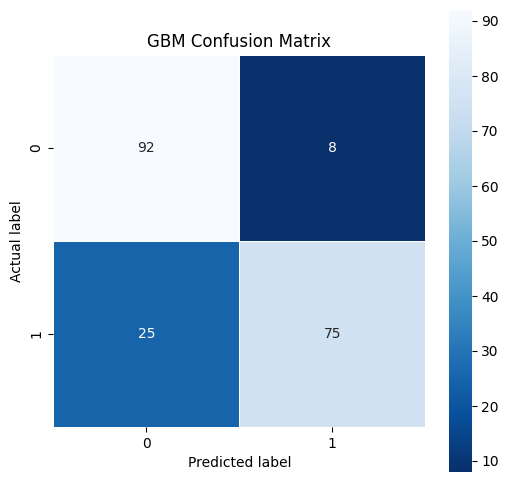

In [512]:
cm_gbm = confusion_matrix(y_test, y_pred_gbm)  # Ensure both are string or both are numeric
plt.figure(figsize=(6,6))
sns.heatmap(cm_gbm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('GBM Confusion Matrix')
plt.show()


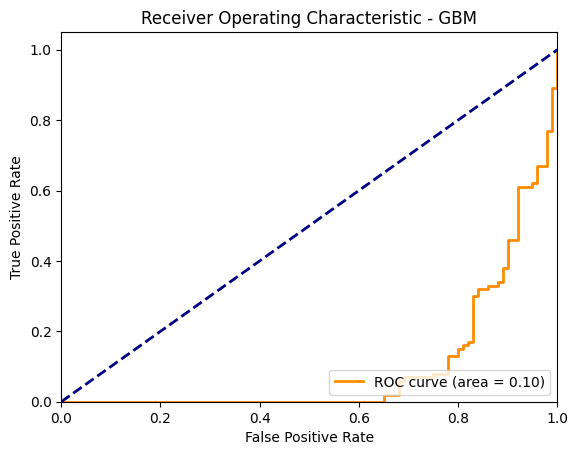

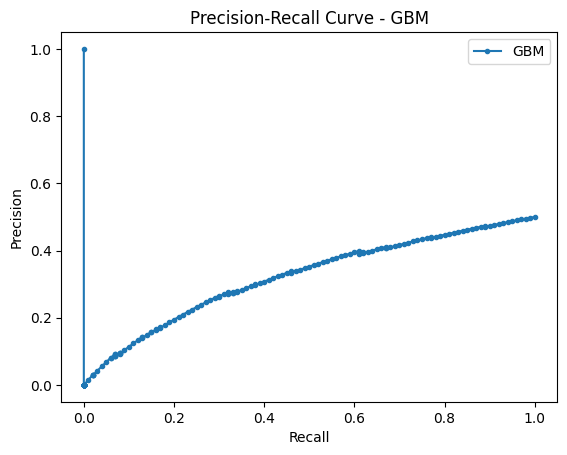

In [513]:
# ROC Curve for GBM
fpr, tpr, thresholds = roc_curve(y_test.replace({'Active': 1, 'Inactive': 0}), gbm.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - GBM')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test.replace({'Active': 1, 'Inactive': 0}), gbm.predict_proba(X_test_scaled)[:, 1])
plt.plot(recall, precision, marker='.', label='GBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GBM')
plt.legend()
plt.show()

In [514]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,569 (21.75 KB)

 Non-trainable params: 0 (0.00 B)

In [515]:
# Convert categorical binary_time_group to numeric
y_train = y_train.map({'Active': 1, 'Inactive': 0}).astype('float')

In [516]:
# Check if conversion was successful
print(y_train.dtype)

# Re-run the model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

float64
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5147 - loss: 0.6996 - val_accuracy: 0.5250 - val_loss: 0.6921
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5878 - loss: 0.6828 - val_accuracy: 0.5375 - val_loss: 0.6884
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6645 - loss: 0.6654 - val_accuracy: 0.6062 - val_loss: 0.6819
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7201 - loss: 0.6504 - val_accuracy: 0.6062 - val_loss: 0.6813
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7096 - loss: 0.6469 - val_accuracy: 0.6187 - val_loss: 0.6738
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7292 - loss: 0.6269 - val_accuracy: 0.6187 - val_loss: 0.6689
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7438 - loss: 0.6189 - val_accuracy: 0.6313 - val_loss: 0.6642
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7340 - loss: 0.6004 - val_accuracy: 0.6313 - 

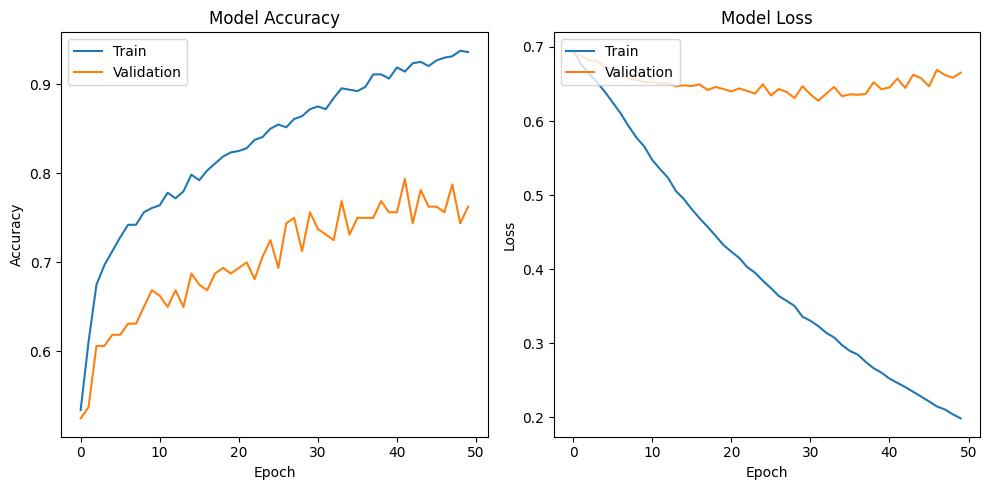

In [517]:
# Summarize history for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [518]:
y_test = y_test.replace({'Active': 1, 'Inactive': 0})

In [519]:

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

7/7 - 0s - 38ms/step - accuracy: 0.7500 - loss: 0.6310
Test Accuracy: 0.7500
Test Loss: 0.6310


In [520]:
# Save the model to disk
with open(os.path.join(BASE_FILE_PATH, 'gbm_model.pkl'), 'wb') as file:
    pickle.dump(gbm, file)
